In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
import torch
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from datasets import load_dataset
from transformers import BlipProcessor, BlipForQuestionAnswering
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

dataset = load_dataset("merve/vqav2-small")
model_name = "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForQuestionAnswering.from_pretrained(model_name).eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/403 [00:00<?, ?B/s]

validation-00000-of-00007.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

validation-00001-of-00007.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00002-of-00007.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

validation-00003-of-00007.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00004-of-00007.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

validation-00005-of-00007.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

validation-00006-of-00007.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/21435 [00:00<?, ? examples/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

DatasetDict({
    validation: Dataset({
        features: ['multiple_choice_answer', 'question', 'image'],
        num_rows: 21435
    })
})


In [ ]:
target_entities = {'dog', 'cat', 'car', 'tree', 'soccer'}

def extract_entity_representation(image, question):
    """Extract hidden state representation for the target entity in the model's answer."""
    inputs = processor(image, question, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs)

    answer = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    found_entities = [word for word in target_entities if word in answer.lower()]
    if not found_entities:
        return None, None

    encoded_answer = processor.tokenizer(answer, return_tensors="pt").to(device)
    with torch.no_grad():
        text_output = model.text_encoder(**encoded_answer, return_dict=True)

    text_hidden_states = text_output.last_hidden_state
    tokenized_words = processor.tokenizer.convert_ids_to_tokens(encoded_answer.input_ids[0])
    entity_embeddings = {}

    for entity in found_entities:
        if entity in tokenized_words:
            entity_idx = tokenized_words.index(entity)
            entity_embeddings[entity] = text_hidden_states[0, entity_idx].cpu().numpy()

    return entity_embeddings, answer


In [ ]:
concept_representations = {}

print("\n🔄 Extracting representations for target entities...\n")
for entity in target_entities:
    print(f"📌 Processing entity: {entity}")

    entity_representations = []
    entity_images = []
    entity_questions = []

    for sample in tqdm(dataset["validation"], desc=f"Processing {entity}"):
        image = sample["image"]
        question = sample["question"]

        embeddings, answer = extract_entity_representation(image, question)
        if embeddings and entity in embeddings:
            entity_representations.append(embeddings[entity])
            entity_images.append(image)
            entity_questions.append(question)

    if entity_representations:
        concept_representations[entity] = {
            "features_list": np.array(entity_representations),
            "sample_images": entity_images,
            "sample_questions": entity_questions
        }

print("\n✅ Extraction completed for all target entities.")



🔄 Extracting representations for target entities...

📌 Processing entity: soccer


Processing soccer: 100%|██████████| 21435/21435 [37:35<00:00,  9.50it/s]


📌 Processing entity: tree


Processing tree: 100%|██████████| 21435/21435 [37:24<00:00,  9.55it/s]


📌 Processing entity: dog


Processing dog: 100%|██████████| 21435/21435 [37:13<00:00,  9.60it/s]


📌 Processing entity: car


Processing car: 100%|██████████| 21435/21435 [37:13<00:00,  9.59it/s]


📌 Processing entity: cat


Processing cat: 100%|██████████| 21435/21435 [37:20<00:00,  9.57it/s]


✅ Extraction completed for all target entities.


In [ ]:
feature_matric = np.vstack([concept_representations[entity]["features_list"] for entity in concept_representations])
feature_matric -= feature_matric.min()

K = 5
nmf_run = NMF(n_components=K, init="random", solver="mu", max_iter=500, random_state=42)
U = nmf_run.fit_transform(feature_matric)
V = nmf_run.components_


print(f"{U.shape} and {V.shape} ")

(195, 5) and (5, 768) 


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


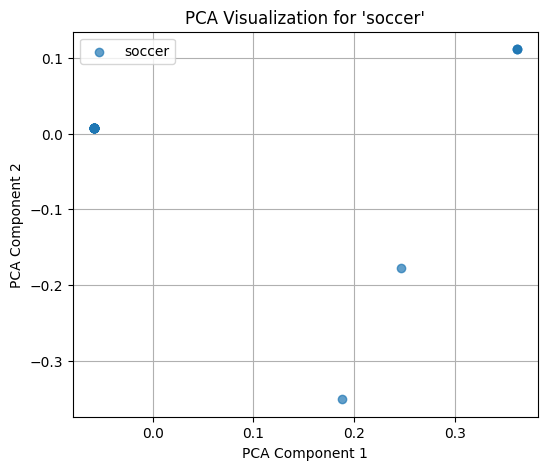

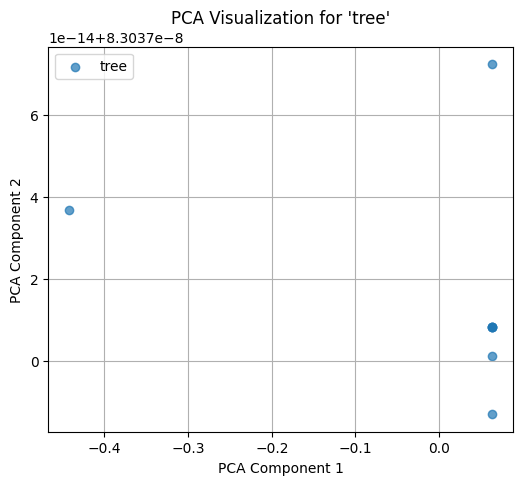

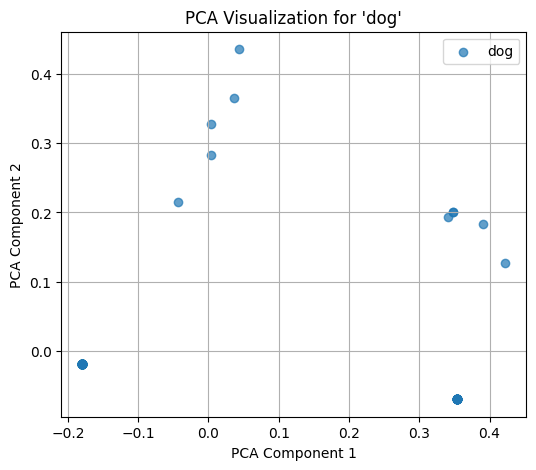

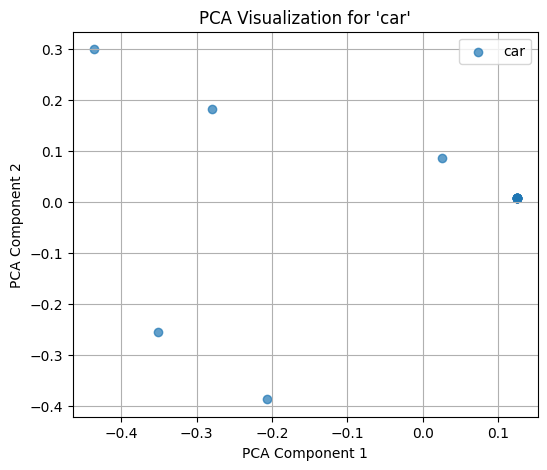

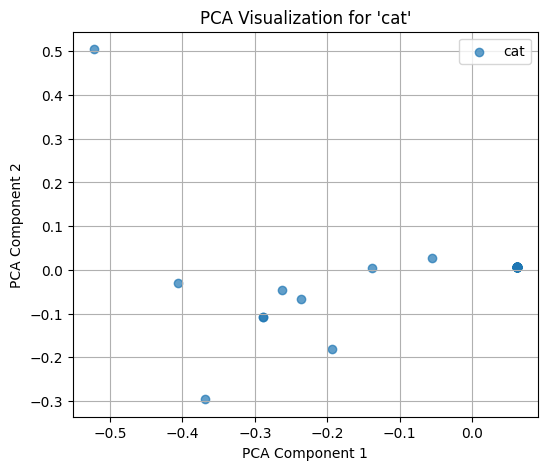

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_entity_embeddings(entity_name, embeddings):
    """Reduce dimensions using PCA and plot embeddings."""
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    plt.figure(figsize=(6, 5))
    plt.scatter(reduced[:, 0], reduced[:, 1], label=entity_name, alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"PCA Visualization for '{entity_name}'")
    plt.legend()
    plt.grid(True)
    plt.show()

for entity, data in concept_representations.items():
    plot_entity_embeddings(entity, data["features_list"])


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_average_cosine_similarity(embeddings):
    """Compute pairwise cosine similarity and return the average."""
    if len(embeddings) < 2:
        return None
    similarities = cosine_similarity(embeddings)
    avg_similarity = np.mean(similarities)
    return avg_similarity

for entity, data in concept_representations.items():
    avg_sim = compute_average_cosine_similarity(data["features_list"])
    if avg_sim is not None:
        print(f"🔍 Average Cosine Similarity for '{entity}': {avg_sim:.4f}")
    else:
        print(f"⚠️ Not enough samples for '{entity}' to compute similarity.")


🔍 Average Cosine Similarity for 'soccer': 0.9893
🔍 Average Cosine Similarity for 'tree': 0.9899
🔍 Average Cosine Similarity for 'dog': 0.9705
🔍 Average Cosine Similarity for 'car': 0.9643
🔍 Average Cosine Similarity for 'cat': 0.9840


In [ ]:
from sklearn.decomposition import PCA

def apply_pca(embeddings, n_components=5):
    """Apply PCA to reduce dimensionality."""
    n_components = min(n_components, len(embeddings))
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

for entity, data in concept_representations.items():
    if len(data["features_list"]) >= 2:
        reduced_embeddings = apply_pca(data["features_list"])
        print(f"✅ PCA applied for '{entity}', reduced to {reduced_embeddings.shape[1]} components.")
    else:
        print(f"⚠️ Not enough samples for '{entity}' to apply PCA.")

✅ PCA applied for 'soccer', reduced to 5 components.
✅ PCA applied for 'tree', reduced to 5 components.
✅ PCA applied for 'dog', reduced to 5 components.
✅ PCA applied for 'car', reduced to 5 components.
✅ PCA applied for 'cat', reduced to 5 components.


In [ ]:
perturbations = {
    "dog": ["What breed is the dog?", "Is there a puppy in the image?"],
    "cat": ["What color is the cat?", "Does the image contain a kitten?"],
    "car": ["What type of car is this?", "Is there a vehicle in the picture?"],
    "tree": ["What kind of tree is this?", "Are there any plants visible?"],
    "soccer": ["Is soccer being played?", "What sport is in the image?"]
}

def extract_entity_representation_perturbed(image, question):
    """Re-run extraction with a slightly perturbed question."""
    inputs = processor(image, question, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs)

    answer = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    found_entities = [word for word in target_entities if word in answer.lower()]
    if not found_entities:
        return None, None

    encoded_answer = processor.tokenizer(answer, return_tensors="pt").to(device)
    with torch.no_grad():
        text_output = model.text_encoder(**encoded_answer, return_dict=True)

    text_hidden_states = text_output.last_hidden_state
    tokenized_words = processor.tokenizer.convert_ids_to_tokens(encoded_answer.input_ids[0])
    entity_embeddings = {}

    for entity in found_entities:
        if entity in tokenized_words:
            entity_idx = tokenized_words.index(entity)
            entity_embeddings[entity] = text_hidden_states[0, entity_idx].cpu().numpy()

    return entity_embeddings, answer

stability_results = {}

for entity, perturb_questions in perturbations.items():
    if entity not in concept_representations:
        continue

    base_embeddings = concept_representations[entity]["features_list"]
    perturbed_embeddings = []

    for img, _ in zip(concept_representations[entity]["sample_images"], perturb_questions):
        new_embedding, _ = extract_entity_representation_perturbed(img, perturb_questions[0])
        if new_embedding and entity in new_embedding:
            perturbed_embeddings.append(new_embedding[entity])

    if perturbed_embeddings:
        stability_score = compute_average_cosine_similarity(perturbed_embeddings)
        if stability_score is not None:
            print(f"🔄 Stability for '{entity}': {stability_score:.4f}")
            stability_results[entity] = stability_score
        else:
            print(f"⚠️ Not enough perturbed embeddings for '{entity}' to compute stability.")
    else:
        print(f"⚠️ No stable embeddings found for '{entity}'.")


⚠️ Not enough perturbed embeddings for 'dog' to compute stability.
⚠️ No stable embeddings found for 'cat'.
⚠️ No stable embeddings found for 'car'.
⚠️ No stable embeddings found for 'tree'.
⚠️ No stable embeddings found for 'soccer'.


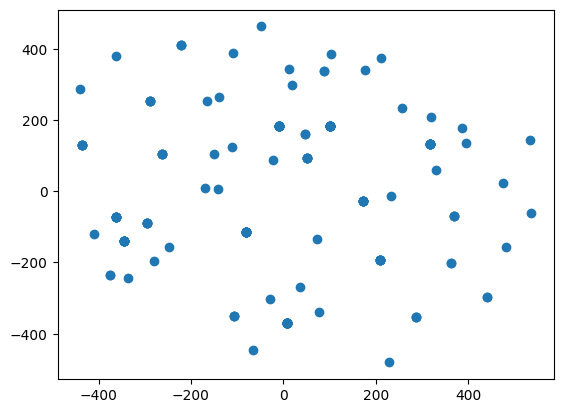

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(np.vstack([data["features_list"] for data in concept_representations.values()]))
plt.scatter(reduced[:,0], reduced[:,1])
plt.show()

In [ ]:
!pip install shap lime torch torchvision transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.4 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sh

In [ ]:
import shap
import torch
import numpy as np
from transformers import BlipProcessor, BlipForQuestionAnswering
from datasets import load_dataset

dataset = load_dataset("merve/vqav2-small")
model_name = "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForQuestionAnswering.from_pretrained(model_name).eval().cuda()

sample = dataset["validation"][0]
image = sample["image"]
question = str(sample["question"])
image_inputs = processor(images=image, return_tensors="pt").to("cuda")
image_pixel_values = image_inputs["pixel_values"]

def model_forward(questions):
    if isinstance(questions[0], list):
        questions = [" ".join(q) for q in questions]
    questions = [str(q) if not isinstance(q, str) else q for q in questions]
    questions = [q.strip() for q in questions]

    print("Cleaned input to model_forward:", questions)
    inputs = processor(images=[image] * len(questions), text=questions, return_tensors="pt", padding=True).to("cuda")

    with torch.no_grad():
        generated_ids = model.generate(**inputs)
        answers = [processor.tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
    return np.array([len(a) for a in answers])



masker = shap.maskers.Text(tokenizer=processor.tokenizer)
explainer = shap.Explainer(model_forward, masker)
shap_values = explainer([question])
shap.text_plot(shap_values)

Cleaned input to model_forward: ['[MASK] [MASK] [MASK] [MASK] [MASK] [MASK]']
Cleaned input to model_forward: ['Where are the kids riding?']
Cleaned input to model_forward: ['Where are the kids riding?', '[MASK] [MASK] [MASK] [MASK] [MASK] [MASK]']
Cleaned input to model_forward: ['Where are the [MASK] [MASK] [MASK]', '[MASK] [MASK] [MASK]kids riding?', 'Where are the [MASK] [MASK] [MASK]', '[MASK] [MASK] [MASK]kids riding?']
Cleaned input to model_forward: ['Where [MASK] [MASK] [MASK] [MASK] [MASK]', '[MASK]are the [MASK] [MASK] [MASK]', 'Where [MASK] [MASK] [MASK] [MASK] [MASK]', '[MASK]are the [MASK] [MASK] [MASK]', 'Where [MASK] [MASK]kids riding?', '[MASK]are the kids riding?']
Cleaned input to model_forward: ['Where are [MASK] [MASK] [MASK] [MASK]', 'Where [MASK]the [MASK] [MASK] [MASK]', 'Where are [MASK] [MASK] [MASK] [MASK]', 'Where [MASK]the [MASK] [MASK] [MASK]', '[MASK]are the [MASK] [MASK] [MASK]', 'Where are the [MASK] [MASK] [MASK]']
Cleaned input to model_forward: ['[MA

  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()
target_entity = "kids"

def predict_fn(img_batch):
    outputs = []

    for img_array in img_batch:
        # Convert float image to uint8
        if img_array.dtype != np.uint8:
            img_array = (img_array * 255).astype(np.uint8)

        img_pil = Image.fromarray(img_array)

        inputs = processor(img_pil, question, return_tensors="pt").to("cuda")

        with torch.no_grad():
            generated_ids = model.generate(**inputs)
        answer = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Label: 1 if entity is present, else 0
        if target_entity.lower() in answer.lower():
            outputs.append([0.0, 1.0])  # Class 1: entity found
        else:
            outputs.append([1.0, 0.0])  # Class 0: entity not found

    return np.array(outputs)




explanation = explainer.explain_instance(
    np.array(image),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=True
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()



  0%|          | 0/1000 [00:00<?, ?it/s]